Credit goes to https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb for the steps to use graph_tool in Colab.

In [ ]:
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard
!pip install gravis

In [2]:
from graph_tool.all import *

g = load_graph("HepPh_with_louvain_and_label.graphml")

In [3]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import numpy as np

date_cutoffs = []

curr_date = datetime.strptime("1995-06-01", "%Y-%m-%d").date()
while curr_date.strftime("%Y-%m-%d") < "2000-06-01":
    date_cutoffs.append(curr_date.strftime("%Y-%m-%d"))
    curr_date += relativedelta(months=+2)

0: 103483.95466819147
1: 121948.8218574046
2: 138685.0908836762
3: 159708.34559162555
4: 178765.34678174305
5: 202215.78944230045
6: 224068.59136257344
7: 250719.44576307922
8: 279252.9261759828
9: 311745.85229764576
10: 339418.36318025115
11: 368099.9609238898
12: 398253.3469622602
13: 439664.30921816465
14: 474593.09453295404
15: 513812.42230849736
16: 551432.0508117747
17: 586449.3385344004
18: 620250.7941830631
19: 663128.9338536186
20: 706970.824228442
21: 750800.3807777188
22: 792721.917739273
23: 836859.4608860032
24: 887320.9938836399
25: 941411.4174281567
26: 994447.7138406895
27: 1049670.4523816905
28: 1100413.0919069208
29: 1153419.721168545


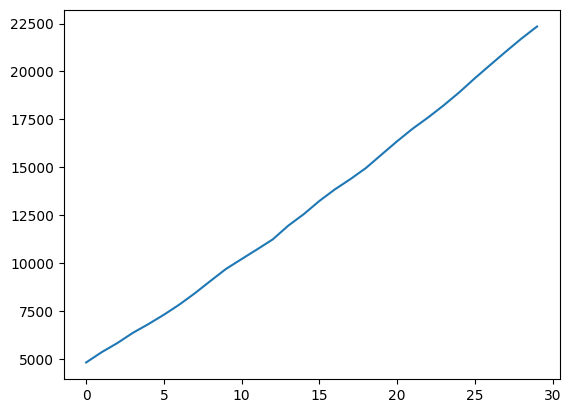

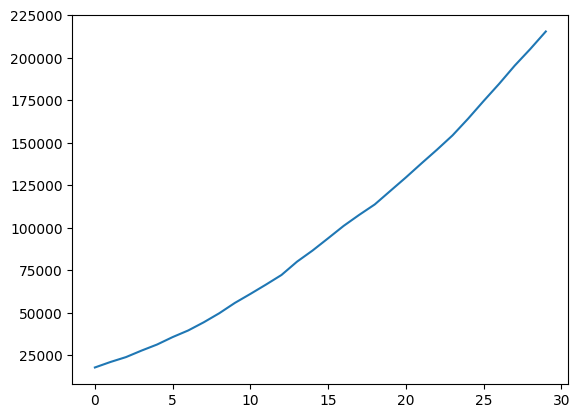

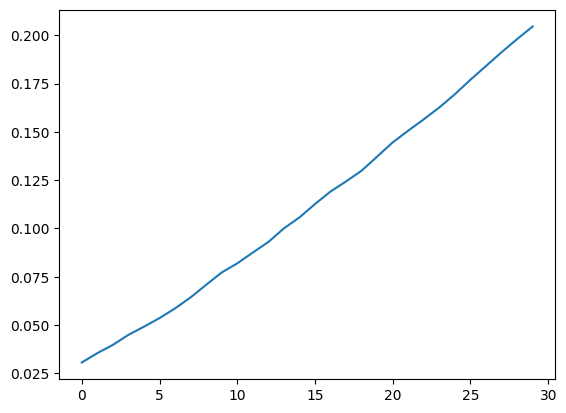

In [4]:
from matplotlib import pyplot
import pickle

num_node_plot = [[],[]]
num_edge_plot = [[],[]]
avg_cc_plot = [[],[]]
community_assignments = []

for slice_idx, date_cutoff in enumerate(date_cutoffs):
    u = GraphView(g, vfilt=lambda v: g.vp.date[v] < date_cutoff)
    u = extract_largest_component(u, directed=False)

    num_node_plot[0].append(slice_idx)
    num_node_plot[1].append(u.num_vertices())

    num_edge_plot[0].append(slice_idx)
    num_edge_plot[1].append(u.num_edges())

    avg_cc_plot[0].append(slice_idx)
    avg_cc_plot[1].append(np.mean(local_clustering(u).a))

    state = minimize_blockmodel_dl(u)
    print(f"{slice_idx}:",state.entropy())

    mask_arr = state.get_blocks().ma

    louv_temp = []
    for val,masked in np.column_stack((mask_arr.data, mask_arr.mask)):
        if masked:
            louv_temp.append(-1)
        else:
            louv_temp.append(val)

    with open(f"sbm_data/original_community_assignments_SBM_{slice_idx}.dump", "wb") as fp:
        pickle.dump(community_assignments, fp)

    community_assignments.append(louv_temp)

pyplot.plot(num_node_plot[0], num_node_plot[1])
pyplot.show()
pyplot.plot(num_edge_plot[0], num_edge_plot[1])
pyplot.show()
pyplot.plot(avg_cc_plot[0], avg_cc_plot[1])
pyplot.show()

In [5]:
from google.colab import files
import pickle

with open("original_community_assignments_SBM.dump", "wb") as fp:
    pickle.dump(community_assignments, fp)

files.download('original_community_assignments_SBM.dump')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
from collections import Counter

with open("original_community_assignments_SBM.dump", "rb") as f:
    community_assignments = pickle.load(f)

# Let us relabel ALL community labels to be unique (except -1s as they are not community labels)
relabelled_comm_assgns = []
curr_max_label = 0
for comm_assgn in community_assignments:
    old_labels = Counter(comm_assgn).keys()
    old_to_new_map = {-1:-1}
    for label in old_labels:
        if label == -1:
            continue
        old_to_new_map[label] = curr_max_label
        curr_max_label += 1

    new_comm_assgn = [old_to_new_map[old_label] for old_label in comm_assgn]
    relabelled_comm_assgns.append(new_comm_assgn)
print(len(relabelled_comm_assgns))
for i in relabelled_comm_assgns:
    print(len(i), end=" ")

30
30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 

In [7]:
# Now get the community sets per time slice
per_slice_comm_sets = []
for relabelled_comm_assgn in relabelled_comm_assgns:
    comm_members = {}
    for node_idx, comm_label in enumerate(relabelled_comm_assgn):
        if comm_label in comm_members:
            comm_members[comm_label].add(node_idx)
        else:
            comm_members[comm_label] = {node_idx}

    comm_sets = [[comm_label, comm_members[comm_label], True] for comm_label in comm_members.keys()]
    # sort the communities by size (desc)
    per_slice_comm_sets.append(sorted(comm_sets, key=lambda x: len(x[1]), reverse=True))

print(len(per_slice_comm_sets))
for i in per_slice_comm_sets:
    print(len(i), end=" ")

30
38 38 43 48 54 58 55 60 72 74 80 84 76 91 87 98 88 106 100 116 122 110 120 118 131 137 127 148 149 150 

In [8]:
# https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py
def jaccard_similarity(set1, set2):
    return float(len(set1.intersection(set2))) / float(len(set1.union(set2)))

# Find similar communities across time slices
for time_slice_idx in range(1, len(per_slice_comm_sets)):
    # Check for each of this slices' communities
    for new_comm_idx,new_comm in enumerate(per_slice_comm_sets[time_slice_idx]):
        # skip if -1
        if new_comm[0] == -1:
            continue

        max_jacque = 0.0
        best_prev_label = -1
        best_prev_label_idx = -1
        for prev_comm_idx,prev_comm in enumerate(per_slice_comm_sets[time_slice_idx-1]):
            # skip if used already or -1
            if prev_comm[0] == -1 or prev_comm[2] == False:
                continue

            # calculate jaccard similarity
            jacque = jaccard_similarity(new_comm[1], prev_comm[1])
            if jacque > max_jacque:
                max_jacque = jacque
                best_prev_label = prev_comm[0]
                best_prev_label_idx = prev_comm_idx

        if best_prev_label != -1:
            # remove prev and set new label
            per_slice_comm_sets[time_slice_idx-1][best_prev_label_idx][2] = False
            per_slice_comm_sets[time_slice_idx][new_comm_idx][0] = per_slice_comm_sets[time_slice_idx-1][best_prev_label_idx][0]
        else:
            # create new label
            per_slice_comm_sets[time_slice_idx][new_comm_idx][0] = curr_max_label
            curr_max_label += 1

In [9]:
# Now we have the temporal communities
# Save and download them
with open("temporal_community_assignments_SBM.dump", "wb") as fp:
    pickle.dump(per_slice_comm_sets, fp)

files.download('temporal_community_assignments_SBM.dump')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of unique communities across slices: 279


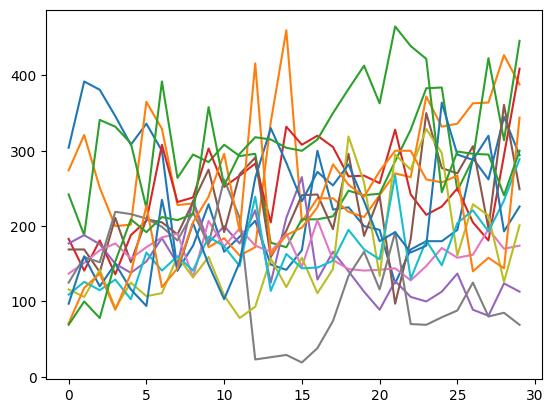

In [10]:
# Lets plot the size of the communities over time!
temporal_comm_size_data = {}
for time_slice_idx,per_slice_comm_set in enumerate(per_slice_comm_sets):
    for comm in per_slice_comm_set:
        if comm[0] == -1:
            continue
        if comm[0] in temporal_comm_size_data:
            temporal_comm_size_data[comm[0]][0].append(time_slice_idx)
            temporal_comm_size_data[comm[0]][1].append(len(comm[1]))
        else:
            temporal_comm_size_data[comm[0]] = [[time_slice_idx],[len(comm[1])]]

print("Number of unique communities across slices:",len(temporal_comm_size_data.keys()))
for comm_label in temporal_comm_size_data.keys():
    if len(temporal_comm_size_data[comm_label][0]) < 30:
        continue
    # print(temporal_comm_size_data[comm_label][0], temporal_comm_size_data[comm_label][1])
    pyplot.plot(temporal_comm_size_data[comm_label][0], temporal_comm_size_data[comm_label][1])
pyplot.show()